In [1]:
from pyomo.environ import (Constraint,
                           Var,
                           ConcreteModel,
                           Expression,
                           Param,
                           Objective,
                           SolverFactory,
                           TransformationFactory,
                           value)

from pyomo.network import Arc, SequentialDecomposition

from idaes.core.util.initialization import propagate_state

# Import plotting functions
import matplotlib.pyplot as plt

# Import numpy library 
import numpy as np

import pandas as pd

# Import the main FlowsheetBlock from IDAES. The flowsheet block will contain the unit model
from idaes.core import FlowsheetBlock

import idaes.logger as idaeslog
from pyomo.opt import TerminationCondition, SolverStatus

# Import the degrees_of_freedom function from the idaes.core.util.model_statistics package
# DOF = Number of Model Variables - Number of Model Constraints
from idaes.core.util.model_statistics import degrees_of_freedom

# Import the Generic Parameter Block
from idaes.generic_models.properties.core.generic.generic_property import (
        GenericParameterBlock)

# Import unit models from the model library
from idaes.generic_models.unit_models import Flash

In [2]:
from R125_bmimBF4_PR import configuration
data = pd.read_csv('R125_bmimBF4.csv')

solver = SolverFactory('ipopt')
solver.options = {'tol': 1e-6}

In [13]:
m = ConcreteModel()

m.fs = FlowsheetBlock(default={"dynamic": False})

m.fs.properties = GenericParameterBlock(default=configuration)

m.fs.F101 = Flash(default={"property_package": m.fs.properties,
                           "has_heat_transfer": True,
                           "has_pressure_change": True})

m.fs.F101.inlet.flow_mol.fix(1)
m.fs.F101.inlet.temperature.fix(323.15)
m.fs.F101.inlet.pressure.fix(399800)
m.fs.F101.inlet.mole_frac_comp[0,'R125'].fix(0.5)

m.fs.properties.PR_kappa_A['bmimBF4', 'R125'].fix(0.35)
m.fs.properties.PR_kappa_A['R125', 'bmimBF4'].fix(0.033)


# Initialize the flash unit
m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)

# Fix the state variables on the state block
# m.fs.F101.inlet.pressure.unfix()
m.fs.F101.inlet.mole_frac_comp[0,'bmimBF4'].unfix()

R125_x = np.zeros((len(data)))
P = np.zeros((len(data)))

m.fs.liq = Param(mutable=True,default=0.040)
m.fs.liquid = Constraint(expr=m.fs.F101.liq_outlet.mole_frac_comp[0, "bmimBF4"] == m.fs.liq)
# m.fs.press = Constraint(expr=m.fs.F101.vap_outlet.pressure[0] <= 1.1e6)
for i in range(len(data)):
    m.fs.liq = data["x_bmimBF4"].iloc[i]
    m.fs.F101.inlet.temperature.fix(float(data["temperature"].iloc[i]))
    m.fs.F101.inlet.pressure.fix(float(data["pressure"].iloc[i]))
    m.fs.F101.inlet.mole_frac_comp[0,'R125'].fix(float(data["x_R125"].iloc[i])+0.1)
    m.fs.F101.inlet.mole_frac_comp[0,'bmimBF4'].fix(float(1-(data["x_R125"].iloc[i]+0.1)))
    m.fs.F101.vap_outlet.temperature.fix(float(data["temperature"].iloc[i]))
#     m.fs.F101.vap_outlet.pressure.fix(float(data["pressure"].iloc[i]))
    print("x =", data["x_bmimBF4"].iloc[i])
    
    try:
        
        m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)
        status = solver.solve(m, tee = False)

        if (status.solver.status == SolverStatus.ok) and (status.solver.termination_condition == TerminationCondition.optimal):

            R125_x[i] = value(m.fs.F101.liq_outlet.mole_frac_comp[0,'R125']) 
            P[i] = value(m.fs.F101.vap_outlet.pressure[0])

        else:
            print('Infeasible.')

    except ValueError:

        R125_x[i] = 'NaN'
        P[i] = 'NaN'

x = 0.992
x = 0.981
x = 0.957
x = 0.899
x = 0.828
x = 0.737
x = 0.622


In [14]:
print(P)
print(data["pressure"])
print(R125_x)
print(data["x_R125"])

[  33453.70206086   78976.50899164  176232.90955831  397621.77009381
  635525.83662752  870119.77672506 1024504.35806375]
0      50000
1     100000
2     200000
3     400000
4     600000
5     799500
6    1000000
Name: pressure, dtype: int64
[0.008 0.019 0.043 0.101 0.172 0.263 0.378]
0    0.008
1    0.019
2    0.043
3    0.101
4    0.172
5    0.263
6    0.378
Name: x_R125, dtype: float64


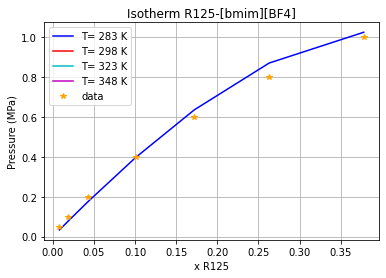

In [15]:
# for i in range(len(P)):
#     P[i] = P[i]*1e6
P1= np.zeros((len(P)))

for i in range(len(P)):
    P1[i] = P[i]/1e6

    
plt.plot(R125_x[0:8],P1[0:8],"b",label="T= 283 K")  
plt.plot(R125_x[8:16],P1[8:16],"r",label="T= 298 K") 
plt.plot(R125_x[16:24],P1[16:24],"c",label="T= 323 K") 
plt.plot(R125_x[24:],P1[24:],"m",label="T= 348 K")
plt.plot(data["x_R125"],data["pressure"]/1e6,"*",color='orange',label="data")  
plt.title('Isotherm R125-[bmim][BF4]')
plt.ylabel('Pressure (MPa)')
plt.xlabel('x R125')
plt.grid(True)
# plt.ylim(0,1.110000)
# plt.xlim(0,0.5)
plt.legend()
plt.show()

In [6]:
m.fs.F101.report()


Unit : fs.F101                                                             Time: 0.0
------------------------------------------------------------------------------------
    Unit Performance

    Variables: 

    Key             : Value      : Fixed : Bounds
          Heat Duty :    -903.31 : False : (None, None)
    Pressure Change : 1.3858e+07 : False : (None, None)

------------------------------------------------------------------------------------
    Stream Table
                              Inlet    Vapor Outlet  Liquid Outlet
    flow_mol                   1.0000      0.16077       0.83923  
    mole_frac_comp bmimBF4    0.52200   1.0000e-08       0.62200  
    mole_frac_comp R125       0.47800       1.0000       0.37800  
    temperature                283.20       283.20        283.20  
    pressure               1.0000e+06   1.4858e+07    1.4858e+07  


In [7]:
# print(P1)

In [8]:
df = pd.DataFrame(P)
# df.to_csv('P_cons_125.csv')
# df.to_csv('P_lin_125.csv')
# df.to_csv('P_ter_125.csv')

In [9]:
# m.display()